<a href="https://colab.research.google.com/github/DSNortsev/CSE696-CECS_PROJECT/blob/master/CSE_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

View system information

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

# Load data from local SCV files

In [ ]:
# Load from local files
import pandas as pd
import numpy as np
import glob

# Path to csv files
covid_data = 'Data/covid/*.csv'
vaccination_usa = 'Data/vaccinations/us.csv'
vaccination_usa_state = 'Data/vaccinations/us_state_vaccinations.csv'


def read_multiple_csv(regex_path):
    data = pd.DataFrame()
    # Read all css files per day comnine in one dataset
    for file in glob.glob(covid_data):
        df = pd.read_csv(file)
        # Check if "Last_update" column has null values, fill it with forward fill
        # propagate[s] last valid observation forward to next valid
        if df['Last_Update'].isna().sum() > 0:
            df.fillna(method='ffill', inplace=True)
        # Remove invalid states from dataset
        df = df[~df['Province_State'].isin(['Diamond Princess', 'Grand Princess', 'Recovered'])]
        # Set Recovered field to 0 when no confirmed cases
        df['Recovered'] = df.apply(lambda x: x['Confirmed'] if x['Confirmed']==0 else x['Recovered'], axis=1)
        data = data.append(df,ignore_index=True)
    return data


# Load data
vac_usa_data = pd.read_csv(vaccination_usa)
vac_state_data = pd.read_csv(vaccination_usa_state)
covid_data = read_multiple_csv(covid_data)

# Load SCV files from remote github repository

In [2]:
from urllib.request import urlopen
import pandas as pd
import numpy as np
import re

# Example of github link
# https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/us_state_vaccinations.csv

# Hopkins covid 19 dataset
git_raw_domain = 'https://raw.githubusercontent.com/'
covid_url = "https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports_us"

# URL Link to cvs file for vaccination in USA by day
url_vaccination_usa = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/'\
                       + 'country_data/United%20States.csv'
# URL Link to cvs file for vaccination in USA by state
url_vaccination_state = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/'\
                       + 'us_state_vaccinations.csv'

url_state_population = 'https://raw.githubusercontent.com/JoshData/historical-state-population-csv/primary/historical_state_population_by_year.csv'


def load_file_from_github(url, raw_domain):
    """
        Load file from github:
            url - github url for all csv files
            raw_domain  - domain to get raw csv file
    """
    # Get github page
    txt = urlopen(url).read().decode('utf8')
    links = re.findall("href=[\"\'](.*?csv)[\"\']", txt)
    # Create pandas DataFrame
    data = pd.DataFrame()

    for link in links:
        df = pd.read_csv(raw_domain + link.replace('blob/', ''),error_bad_lines=False)
        # Check if "Last_update" column has null values, fill it with forward fill
        # propagate[s] last valid observation forward to next valid
        if df['Last_Update'].isna().sum() > 0:
            # Each file should be for one specific day
            df.fillna(method='ffill', inplace=True)
        # Remove invalid states from dataset
        df = df[~df['Province_State'].isin(['Diamond Princess', 'Grand Princess', 'Recovered'])]
        # Set Recovered field to 0 when no confirmed cases
        df['Recovered'] = df.apply(lambda x: x['Confirmed'] if x['Confirmed']==0 else x['Recovered'], axis=1)
        data = data.append(df,ignore_index=True)
    return data

# Load data
vac_usa_data = pd.read_csv(url_vaccination_usa,error_bad_lines=False)
vac_state_data = pd.read_csv(url_vaccination_state,error_bad_lines=False)
covid_data = load_file_from_github(covid_url, git_raw_domain)
population_state = pd.read_csv(url_state_population, error_bad_lines=False)

# Handling missing values

In [3]:
# Rename columns in population dataset
population_state.columns = ['State', 'Year', 'Population']
# Get population for 2019
population_state = population_state[population_state['Year'] == 2019].reset_index(drop=True)
population_state = population_state[['State', 'Population']]
population_state

,State,Population
0,AK,731545
1,AL,4903185
2,AR,3017804
3,AZ,7278717
4,CA,39512223
5,CO,5758736
6,CT,3565287
7,DC,705749
8,DE,973764
9,FL,21477737


In [4]:
# Sort dataset by date
vac_usa_data = vac_usa_data.sort_values(by='date')
vac_usa_data

,location,date,vaccine,source_url,total_vaccinations,people_vaccinated,people_fully_vaccinated
0,United States,2020-12-20,Pfizer/BioNTech,https://www.cdc.gov/coronavirus/2019-ncov/vacc...,556208,556208.0,NaN
1,United States,2020-12-21,Pfizer/BioNTech,https://covid.cdc.gov/covid-data-tracker/#vacc...,614117,614117.0,NaN
2,United States,2020-12-23,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,1008025,1008025.0,NaN
3,United States,2020-12-26,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,1944585,1944585.0,NaN
4,United States,2020-12-28,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,2127143,2127143.0,NaN
...,...,...,...,...,...,...,...
79,United States,2021-03-23,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,128217029,83930495.0,45533962.0
80,United States,2021-03-24,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,130473853,85472166.0,46365515.0
81,United States,2021-03-25,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,133305295,87343622.0,47419832.0
82,United States,2021-03-26,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,136684688,89559225.0,48695172.0


In [5]:
vac_usa_data.dtypes

location                    object
date                        object
vaccine                     object
source_url                  object
total_vaccinations           int64
people_vaccinated          float64
people_fully_vaccinated    float64
dtype: object

In [6]:
# Sort dataset by date
vac_state_dat = vac_state_data.sort_values(by='date')
vac_state_dat

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
4180,2020-12-20,United States,556208.0,NaN,NaN,NaN,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4181,2020-12-21,United States,614117.0,NaN,NaN,NaN,0.18,NaN,NaN,NaN,57909.000000,57909.0,174.0,NaN
4182,2020-12-22,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196954.000000,127432.0,384.0,NaN
4183,2020-12-23,United States,1008025.0,NaN,NaN,NaN,0.30,NaN,NaN,NaN,196954.000000,150606.0,454.0,NaN
4184,2020-12-24,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312186.666667,191001.0,575.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4886,2021-03-28,Wisconsin,2808953.0,2996415.0,1794367.0,17.85,48.24,1039433.0,30.82,51.46,72208.000000,55149.0,9472.0,0.937
1367,2021-03-28,Idaho,728042.0,910095.0,448334.0,15.79,40.74,282222.0,25.09,50.93,17166.000000,12634.0,7070.0,0.800
1291,2021-03-28,Hawaii,662115.0,890600.0,422366.0,17.77,46.76,251645.0,29.83,62.90,1213.000000,7371.0,5206.0,0.743
3799,2021-03-28,Republic of Palau,13381.0,15000.0,8401.0,29.32,74.72,5250.0,46.91,83.77,47.000000,225.0,12565.0,0.892


In [7]:
vac_state_data.dtypes

date                                    object
location                                object
total_vaccinations                     float64
total_distributed                      float64
people_vaccinated                      float64
people_fully_vaccinated_per_hundred    float64
total_vaccinations_per_hundred         float64
people_fully_vaccinated                float64
people_vaccinated_per_hundred          float64
distributed_per_hundred                float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
daily_vaccinations_per_million         float64
share_doses_used                       float64
dtype: object

In [8]:
# Sort dataset by date
covid_data = covid_data.sort_values(by=['Last_Update', 'Province_State'])
covid_data

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate
4816,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3667,93,NaN,3470.0,1.0,75.988020,NaN,437.0,NaN,84000001.0,USA,460.300152,12.264945,21583.0,2.610160
4817,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,NaN,31.0,NaN,84000002.0,USA,1344.711576,11.397059,8038.0,2.941176
4869,American Samoa,US,2020-04-12 23:18:15,-14.2710,-170.1322,0,0,0.0,0.0,60.0,0.000000,NaN,40.0,NaN,16.0,ASM,5.391708,14.814815,3.0,0.000000
4818,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,66.0,3427.0,4.0,48.662422,NaN,31.0,NaN,84000004.0,USA,578.522286,11.397059,52289.0,3.246753
4819,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,49.439423,NaN,130.0,NaN,84000005.0,USA,761.753354,10.156250,19722.0,2.109375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4812,Washington,US,2021-03-28 05:31:16,47.4009,-121.4905,361115,5218,NaN,NaN,53.0,4742.220278,5802332.0,NaN,1.444969,84000053.0,USA,76197.157334,NaN,NaN,NaN
4813,West Virginia,US,2021-03-28 05:31:16,38.4912,-80.9545,140316,2631,NaN,NaN,54.0,7829.491666,2434554.0,NaN,1.875053,84000054.0,USA,135845.664446,NaN,NaN,NaN
4814,Wisconsin,US,2021-03-28 05:31:16,44.2685,-89.6165,633663,7274,NaN,NaN,55.0,10883.128946,7516428.0,NaN,1.147929,84000055.0,USA,129094.258518,NaN,NaN,NaN
4815,Wyoming,US,2021-03-28 05:31:16,42.7560,-107.3025,56046,695,NaN,NaN,56.0,9683.823491,679984.0,NaN,1.240053,84000056.0,USA,117490.008795,NaN,NaN,NaN


In [9]:
covid_data.dtypes

Province_State           object
Country_Region           object
Last_Update              object
Lat                     float64
Long_                   float64
Confirmed                 int64
Deaths                    int64
Recovered               float64
Active                  float64
FIPS                    float64
Incident_Rate           float64
Total_Test_Results      float64
People_Hospitalized     float64
Case_Fatality_Ratio     float64
UID                     float64
ISO3                     object
Testing_Rate            float64
Hospitalization_Rate    float64
People_Tested           float64
Mortality_Rate          float64
dtype: object

In [10]:
# Rename columns
covid_data.rename(columns = {'Province_State':'location', 'Last_Update': 'date' }, inplace = True)
covid_data

,location,Country_Region,date,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate
4816,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3667,93,NaN,3470.0,1.0,75.988020,NaN,437.0,NaN,84000001.0,USA,460.300152,12.264945,21583.0,2.610160
4817,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,NaN,31.0,NaN,84000002.0,USA,1344.711576,11.397059,8038.0,2.941176
4869,American Samoa,US,2020-04-12 23:18:15,-14.2710,-170.1322,0,0,0.0,0.0,60.0,0.000000,NaN,40.0,NaN,16.0,ASM,5.391708,14.814815,3.0,0.000000
4818,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,66.0,3427.0,4.0,48.662422,NaN,31.0,NaN,84000004.0,USA,578.522286,11.397059,52289.0,3.246753
4819,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,49.439423,NaN,130.0,NaN,84000005.0,USA,761.753354,10.156250,19722.0,2.109375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4812,Washington,US,2021-03-28 05:31:16,47.4009,-121.4905,361115,5218,NaN,NaN,53.0,4742.220278,5802332.0,NaN,1.444969,84000053.0,USA,76197.157334,NaN,NaN,NaN
4813,West Virginia,US,2021-03-28 05:31:16,38.4912,-80.9545,140316,2631,NaN,NaN,54.0,7829.491666,2434554.0,NaN,1.875053,84000054.0,USA,135845.664446,NaN,NaN,NaN
4814,Wisconsin,US,2021-03-28 05:31:16,44.2685,-89.6165,633663,7274,NaN,NaN,55.0,10883.128946,7516428.0,NaN,1.147929,84000055.0,USA,129094.258518,NaN,NaN,NaN
4815,Wyoming,US,2021-03-28 05:31:16,42.7560,-107.3025,56046,695,NaN,NaN,56.0,9683.823491,679984.0,NaN,1.240053,84000056.0,USA,117490.008795,NaN,NaN,NaN


## Handle NaN values in COVID dataset 

In [11]:
# Convert data to YYYY-MM-DD format
covid_data['date'] = pd.to_datetime(covid_data['date'], format='%Y/%m/%d %H:%M:%S').dt.strftime('%Y-%m-%d')
covid_data

,location,Country_Region,date,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate
4816,Alabama,US,2020-04-12,32.3182,-86.9023,3667,93,NaN,3470.0,1.0,75.988020,NaN,437.0,NaN,84000001.0,USA,460.300152,12.264945,21583.0,2.610160
4817,Alaska,US,2020-04-12,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,NaN,31.0,NaN,84000002.0,USA,1344.711576,11.397059,8038.0,2.941176
4869,American Samoa,US,2020-04-12,-14.2710,-170.1322,0,0,0.0,0.0,60.0,0.000000,NaN,40.0,NaN,16.0,ASM,5.391708,14.814815,3.0,0.000000
4818,Arizona,US,2020-04-12,33.7298,-111.4312,3542,115,66.0,3427.0,4.0,48.662422,NaN,31.0,NaN,84000004.0,USA,578.522286,11.397059,52289.0,3.246753
4819,Arkansas,US,2020-04-12,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,49.439423,NaN,130.0,NaN,84000005.0,USA,761.753354,10.156250,19722.0,2.109375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4812,Washington,US,2021-03-28,47.4009,-121.4905,361115,5218,NaN,NaN,53.0,4742.220278,5802332.0,NaN,1.444969,84000053.0,USA,76197.157334,NaN,NaN,NaN
4813,West Virginia,US,2021-03-28,38.4912,-80.9545,140316,2631,NaN,NaN,54.0,7829.491666,2434554.0,NaN,1.875053,84000054.0,USA,135845.664446,NaN,NaN,NaN
4814,Wisconsin,US,2021-03-28,44.2685,-89.6165,633663,7274,NaN,NaN,55.0,10883.128946,7516428.0,NaN,1.147929,84000055.0,USA,129094.258518,NaN,NaN,NaN
4815,Wyoming,US,2021-03-28,42.7560,-107.3025,56046,695,NaN,NaN,56.0,9683.823491,679984.0,NaN,1.240053,84000056.0,USA,117490.008795,NaN,NaN,NaN


In [12]:
# Find all missing values
covid_data.isna().sum()

location                    0
Country_Region              0
date                        0
Lat                         0
Long_                       0
Confirmed                   0
Deaths                      0
Recovered                3977
Active                   1185
FIPS                        0
Incident_Rate               0
Total_Test_Results      11816
People_Hospitalized     14408
Case_Fatality_Ratio     11955
UID                         0
ISO3                        0
Testing_Rate                0
Hospitalization_Rate    14408
People_Tested            7784
Mortality_Rate           7986
dtype: int64

In [13]:
# Drop columns that have more than 60-70% of missing values
# 17360 rows / 11915 = 0.68
covid_data.drop(['People_Hospitalized', 'Hospitalization_Rate', 
                'Total_Test_Results', 'Case_Fatality_Ratio'], axis=1, inplace=True)

In [14]:
covid_data.isna().sum()

location             0
Country_Region       0
date                 0
Lat                  0
Long_                0
Confirmed            0
Deaths               0
Recovered         3977
Active            1185
FIPS                 0
Incident_Rate        0
UID                  0
ISO3                 0
Testing_Rate         0
People_Tested     7784
Mortality_Rate    7986
dtype: int64

In [15]:
# Create tmp DataFrame with missing values and States
df_nan = covid_data[['location','Recovered', 'People_Tested', 'Mortality_Rate', 'Active']]
# Group by State and use interpolate method to fill out missing values with previous value for the same state
df_interpolated = df_nan.groupby('location').apply(lambda x: x.interpolate(method='linear'))
# Check that missing value amount is drastically reduced
df_interpolated.isna().sum()

location           0
Recovered         18
People_Tested      0
Mortality_Rate     0
Active             0
dtype: int64

In [16]:
df_interpolated

,location,Recovered,People_Tested,Mortality_Rate,Active
4816,Alabama,NaN,21583.0,2.610160,3470.0
4817,Alaska,66.0,8038.0,2.941176,264.0
4869,American Samoa,0.0,3.0,0.000000,0.0
4818,Arizona,66.0,52289.0,3.246753,3427.0
4819,Arkansas,367.0,19722.0,2.109375,1253.0
...,...,...,...,...,...
4812,Washington,0.0,2592766.0,2.078735,339491.0
4813,West Virginia,124502.0,849461.0,1.774398,6465.0
4814,Wisconsin,552311.0,3564737.0,0.864590,61861.0
4815,Wyoming,53550.0,141079.0,0.658579,532.0


In [17]:
# Group by state and  fill out missing values with mean value 
df_means = df_interpolated.groupby('location').transform(lambda x:x.fillna(x.mean()))
# Update original DataFrame with new values
covid_data.update(df_means)
covid_data.isna().sum()

location          0
Country_Region    0
date              0
Lat               0
Long_             0
Confirmed         0
Deaths            0
Recovered         0
Active            0
FIPS              0
Incident_Rate     0
UID               0
ISO3              0
Testing_Rate      0
People_Tested     0
Mortality_Rate    0
dtype: int64

In [18]:
covid_data

,location,Country_Region,date,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,ISO3,Testing_Rate,People_Tested,Mortality_Rate
4816,Alabama,US,2020-04-12,32.3182,-86.9023,3667,93,113441.724398,3470.0,1.0,75.988020,84000001.0,USA,460.300152,21583.0,2.610160
4817,Alaska,US,2020-04-12,61.3707,-152.4044,272,8,66.000000,264.0,2.0,45.504049,84000002.0,USA,1344.711576,8038.0,2.941176
4869,American Samoa,US,2020-04-12,-14.2710,-170.1322,0,0,0.000000,0.0,60.0,0.000000,16.0,ASM,5.391708,3.0,0.000000
4818,Arizona,US,2020-04-12,33.7298,-111.4312,3542,115,66.000000,3427.0,4.0,48.662422,84000004.0,USA,578.522286,52289.0,3.246753
4819,Arkansas,US,2020-04-12,34.9697,-92.3731,1280,27,367.000000,1253.0,5.0,49.439423,84000005.0,USA,761.753354,19722.0,2.109375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4812,Washington,US,2021-03-28,47.4009,-121.4905,361115,5218,0.000000,339491.0,53.0,4742.220278,84000053.0,USA,76197.157334,2592766.0,2.078735
4813,West Virginia,US,2021-03-28,38.4912,-80.9545,140316,2631,124502.000000,6465.0,54.0,7829.491666,84000054.0,USA,135845.664446,849461.0,1.774398
4814,Wisconsin,US,2021-03-28,44.2685,-89.6165,633663,7274,552311.000000,61861.0,55.0,10883.128946,84000055.0,USA,129094.258518,3564737.0,0.864590
4815,Wyoming,US,2021-03-28,42.7560,-107.3025,56046,695,53550.000000,532.0,56.0,9683.823491,84000056.0,USA,117490.008795,141079.0,0.658579


## Handle NaN values in Vaccination dataset in USA

In [19]:
vac_usa_data

,location,date,vaccine,source_url,total_vaccinations,people_vaccinated,people_fully_vaccinated
0,United States,2020-12-20,Pfizer/BioNTech,https://www.cdc.gov/coronavirus/2019-ncov/vacc...,556208,556208.0,NaN
1,United States,2020-12-21,Pfizer/BioNTech,https://covid.cdc.gov/covid-data-tracker/#vacc...,614117,614117.0,NaN
2,United States,2020-12-23,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,1008025,1008025.0,NaN
3,United States,2020-12-26,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,1944585,1944585.0,NaN
4,United States,2020-12-28,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,2127143,2127143.0,NaN
...,...,...,...,...,...,...,...
79,United States,2021-03-23,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,128217029,83930495.0,45533962.0
80,United States,2021-03-24,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,130473853,85472166.0,46365515.0
81,United States,2021-03-25,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,133305295,87343622.0,47419832.0
82,United States,2021-03-26,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,136684688,89559225.0,48695172.0


In [20]:
vac_usa_data.isna().sum()

location                    0
date                        0
vaccine                     0
source_url                  0
total_vaccinations          0
people_vaccinated           1
people_fully_vaccinated    15
dtype: int64

In [21]:
# Fill missing value with mean value in people_vaccinated column
vac_usa_data['people_vaccinated'].fillna((vac_usa_data['people_vaccinated'].mean()), inplace=True)
vac_usa_data.isna().sum()

location                    0
date                        0
vaccine                     0
source_url                  0
total_vaccinations          0
people_vaccinated           0
people_fully_vaccinated    15
dtype: int64

In [22]:
vac_usa_data['people_fully_vaccinated'].fillna(0, inplace=True)
vac_usa_data.isna().sum()

location                   0
date                       0
vaccine                    0
source_url                 0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
dtype: int64

## Handle NaN values in Vaccination dataset in USA by state

In [23]:
vac_state_data

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,2021-03-24,Wyoming,235424.0,336475.0,142147.0,15.97,40.68,92428.0,24.56,58.14,253.0,3058.0,5284.0,0.700
4959,2021-03-25,Wyoming,242919.0,350735.0,146634.0,16.54,41.97,95709.0,25.34,60.60,7495.0,4124.0,7126.0,0.693
4960,2021-03-26,Wyoming,243336.0,351435.0,146888.0,16.56,42.04,95871.0,25.38,60.72,417.0,3229.0,5579.0,0.692
4961,2021-03-27,Wyoming,243604.0,353975.0,147098.0,16.61,42.09,96104.0,25.42,61.16,268.0,3230.0,5581.0,0.688


In [24]:
vac_state_data.isna().sum()

date                                     0
location                                 0
total_vaccinations                     270
total_distributed                      352
people_vaccinated                      364
people_fully_vaccinated_per_hundred    692
total_vaccinations_per_hundred         590
people_fully_vaccinated                446
people_vaccinated_per_hundred          615
distributed_per_hundred                603
daily_vaccinations_raw                  65
daily_vaccinations                      65
daily_vaccinations_per_million         400
share_doses_used                       352
dtype: int64

In [25]:
# Find all unique states in vac_state_data dataset
vac_states = vac_state_data['location'].unique()
vac_states

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'Bureau of Prisons', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'Dept of Defense', 'District of Columbia',
       'Federated States of Micronesia', 'Florida', 'Georgia', 'Guam',
       'Hawaii', 'Idaho', 'Illinois', 'Indian Health Svc', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Long Term Care', 'Louisiana',
       'Maine', 'Marshall Islands', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York State', 'North Carolina', 'North Dakota',
       'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Republic of Palau', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
       'United States', 'Utah', 'Vermont', 'Veterans Health',
       'Virgin Islands', 'Virginia', 'Washington', 'West V

In [26]:
# Find all unique states in covid_date dataset
data_states = covid_data['location'].unique()
data_states 

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [27]:
# Find difference between two tables 
np.setdiff1d(vac_states, data_states)

array(['Bureau of Prisons', 'Dept of Defense',
       'Federated States of Micronesia', 'Indian Health Svc',
       'Long Term Care', 'Marshall Islands', 'New York State',
       'Republic of Palau', 'United States', 'Veterans Health'],
      dtype=object)

In [28]:
# Find difference between two tables 
np.setdiff1d(data_states, vac_states)

array(['New York'], dtype=object)

In [30]:
# Drop island's data
vac_state_data = vac_state_data[~vac_state_data['location'].isin(['Federated States of Micronesia', 'Marshall Islands', 'Republic of Palau'])]
# Change "New York State" to "New York"
vac_state_data['location'].mask(vac_state_data['location'] == 'New York State', 'New York', inplace=True)

In [31]:
# Aggregate Indian Health Svc and Indiana
tmp = vac_state_data[vac_state_data['location'].isin(['Indian Health Svc', 'Indiana'])].copy()
tmp = tmp.groupby('date', as_index=False).agg({ 'total_vaccinations': np.sum,
                          'total_distributed': np.sum,
                          'people_vaccinated': np.sum,
                          'people_fully_vaccinated_per_hundred': np.mean,
                          'total_vaccinations_per_hundred': np.mean,
                          'people_fully_vaccinated': np.sum, 
                          'people_vaccinated_per_hundred': np.mean,
                          'distributed_per_hundred': np.mean,
                          'daily_vaccinations_raw': np.sum,
                          'daily_vaccinations': np.sum,
                          'daily_vaccinations_per_million': np.mean,
                          'share_doses_used': np.mean,
                                                    
})
# Add location column
tmp['location'] = 'Indiana'
vac_state_data.drop(vac_state_data[vac_state_data['location'].isin(['Indian Health Svc', 'Indiana'])].index, inplace=True)
vac_state_data = vac_state_data.append(tmp, ignore_index = True)


In [32]:
vac_state_data

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.150,1.590,7270.0,1.450,7.690,NaN,NaN,NaN,0.2070
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.190,1.710,9245.0,1.530,7.730,5906.0,5906.0,1205.0,0.2220
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.880,NaN,1.640,8.880,8260.0,7083.0,1445.0,0.2120
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.280,2.050,13488.0,1.770,9.070,8267.0,7478.0,1525.0,0.2260
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,2021-03-24,Indiana,3364911.0,4579865.0,2078803.0,15.000,39.515,1308515.0,24.660,57.535,57468.0,53800.0,6238.5,0.7025
4655,2021-03-25,Indiana,3426954.0,4610065.0,2116972.0,15.275,40.145,1334641.0,25.040,57.760,62043.0,53641.0,6049.5,0.7105
4656,2021-03-26,Indiana,3502377.0,4677745.0,2161512.0,15.665,40.995,1368434.0,25.535,58.955,75423.0,54776.0,6181.0,0.7135
4657,2021-03-27,Indiana,3574247.0,4790635.0,2204106.0,16.035,41.785,1400175.0,25.975,59.830,71870.0,55061.0,6250.5,0.7130


In [33]:
tmp 

,date,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,location
0,2021-01-12,260231.0,764900.0,130886.0,0.350,2.850,23782.0,1.700,8.030,0.00,0.0,NaN,0.3300,Indiana
1,2021-01-13,285796.0,869950.0,143003.0,0.480,3.140,32363.0,1.870,8.600,25565.00,25565.0,2895.0,0.3105,Indiana
2,2021-01-14,315214.0,921825.0,273202.0,NaN,3.470,0.0,3.030,9.360,29418.00,27492.0,3093.0,0.3255,Indiana
3,2021-01-15,350555.0,935125.0,299908.0,0.560,3.870,50413.0,3.310,9.540,35341.00,30108.0,3390.0,0.3565,Indiana
4,2021-01-16,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,22067.75,28098.0,3233.0,NaN,Indiana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021-03-24,3364911.0,4579865.0,2078803.0,15.000,39.515,1308515.0,24.660,57.535,57468.00,53800.0,6238.5,0.7025,Indiana
72,2021-03-25,3426954.0,4610065.0,2116972.0,15.275,40.145,1334641.0,25.040,57.760,62043.00,53641.0,6049.5,0.7105,Indiana
73,2021-03-26,3502377.0,4677745.0,2161512.0,15.665,40.995,1368434.0,25.535,58.955,75423.00,54776.0,6181.0,0.7135,Indiana
74,2021-03-27,3574247.0,4790635.0,2204106.0,16.035,41.785,1400175.0,25.975,59.830,71870.00,55061.0,6250.5,0.7130,Indiana


In [34]:
# tmp = vac_state_data[vac_state_data['location'].isin(['Bureau of Prisons', 'Dept of Defense', 'Long Term Care',
#        'United States', 'Veterans Health', 'District of Columbia'])]
# tmp = tmp.groupby('date', as_index=False).agg({ 'total_vaccinations': np.sum,
#                           'total_distributed': np.sum,
#                           'people_vaccinated': np.sum,
#                           'people_fully_vaccinated_per_hundred': np.mean,
#                           'total_vaccinations_per_hundred': np.mean,
#                           'people_fully_vaccinated': np.sum, 
#                           'people_vaccinated_per_hundred': np.mean,
#                           'distributed_per_hundred': np.mean,
#                           'daily_vaccinations_raw': np.sum,
#                           'daily_vaccinations': np.sum,
#                           'daily_vaccinations_per_million': np.mean,
#                           'share_doses_used': np.mean,
                                                    
# })
# # Add location column
# tmp['location'] = 'District of Columbia'
# vac_state_data.drop(vac_state_data[vac_state_data['location'].isin(['Bureau of Prisons', 'Dept of Defense', 'Long Term Care',
#        'United States', 'Veterans Health', 'District of Columbia'])].index, inplace = True)
# vac_state_data = vac_state_data.append(tmp, ignore_index = True)
# Do not combine other deparments with DC
vac_state_data.drop(vac_state_data[vac_state_data['location'].isin(['Bureau of Prisons', 'Dept of Defense', 'Long Term Care',
        'United States', 'Veterans Health'])].index, inplace = True)

In [35]:
# Group by location and use interpolate method to fill out missing values with previous value for the same state
df_interpolated = vac_state_data.groupby('location').apply(lambda x: x.interpolate(method='linear'))
# Check that missing value amount is drastically reduced
df_interpolated.isna().sum()

date                                    0
location                                0
total_vaccinations                      0
total_distributed                       0
people_vaccinated                      12
people_fully_vaccinated_per_hundred    33
total_vaccinations_per_hundred          0
people_fully_vaccinated                33
people_vaccinated_per_hundred          12
distributed_per_hundred                 0
daily_vaccinations_raw                 55
daily_vaccinations                     55
daily_vaccinations_per_million         56
share_doses_used                        0
dtype: int64

In [36]:
# Group by state and  fill out missing values with mean value 
df_means = df_interpolated.groupby('location').transform(lambda x:x.fillna(x.mean()))
# Update original DataFrame with new values
vac_state_data.update(df_means)
vac_state_data.isna().sum()

date                                   0
location                               0
total_vaccinations                     0
total_distributed                      0
people_vaccinated                      0
people_fully_vaccinated_per_hundred    0
total_vaccinations_per_hundred         0
people_fully_vaccinated                0
people_vaccinated_per_hundred          0
distributed_per_hundred                0
daily_vaccinations_raw                 0
daily_vaccinations                     0
daily_vaccinations_per_million         0
share_doses_used                       0
dtype: int64

In [37]:
vac_state_data

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.00,0.1500,1.590,7270.0,1.450,7.690,21079.573333,20238.92,4127.68,0.2070
1,2021-01-13,Alabama,84040.0,378975.0,74792.00,0.1900,1.710,9245.0,1.530,7.730,5906.000000,5906.00,1205.00,0.2220
2,2021-01-14,Alabama,92300.0,435350.0,80480.00,0.2350,1.880,11366.5,1.640,8.880,8260.000000,7083.00,1445.00,0.2120
3,2021-01-15,Alabama,100567.0,444650.0,86956.00,0.2800,2.050,13488.0,1.770,9.070,8267.000000,7478.00,1525.00,0.2260
4,2021-01-16,Alabama,108124.0,444650.0,93796.75,0.2925,2.205,14202.5,1.910,9.070,7557.000000,7498.00,1529.00,0.2430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,2021-03-24,Indiana,3364911.0,4579865.0,2078803.00,15.0000,39.515,1308515.0,24.660,57.535,57468.000000,53800.00,6238.50,0.7025
4655,2021-03-25,Indiana,3426954.0,4610065.0,2116972.00,15.2750,40.145,1334641.0,25.040,57.760,62043.000000,53641.00,6049.50,0.7105
4656,2021-03-26,Indiana,3502377.0,4677745.0,2161512.00,15.6650,40.995,1368434.0,25.535,58.955,75423.000000,54776.00,6181.00,0.7135
4657,2021-03-27,Indiana,3574247.0,4790635.0,2204106.00,16.0350,41.785,1400175.0,25.975,59.830,71870.000000,55061.00,6250.50,0.7130


In [38]:
# Merge two Dataframes together
complete_df = pd.merge(covid_data,
                       vac_state_data,
                       on=['date', 'location'], 
                       how='left')
complete_df

,location,Country_Region,date,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,ISO3,Testing_Rate,People_Tested,Mortality_Rate,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,Alabama,US,2020-04-12,32.3182,-86.9023,3667,93,113441.724398,3470.0,1.0,75.988020,84000001.0,USA,460.300152,21583.0,2.610160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alaska,US,2020-04-12,61.3707,-152.4044,272,8,66.000000,264.0,2.0,45.504049,84000002.0,USA,1344.711576,8038.0,2.941176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,American Samoa,US,2020-04-12,-14.2710,-170.1322,0,0,0.000000,0.0,60.0,0.000000,16.0,ASM,5.391708,3.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arizona,US,2020-04-12,33.7298,-111.4312,3542,115,66.000000,3427.0,4.0,48.662422,84000004.0,USA,578.522286,52289.0,3.246753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arkansas,US,2020-04-12,34.9697,-92.3731,1280,27,367.000000,1253.0,5.0,49.439423,84000005.0,USA,761.753354,19722.0,2.109375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19595,Washington,US,2021-03-28,47.4009,-121.4905,361115,5218,0.000000,339491.0,53.0,4742.220278,84000053.0,USA,76197.157334,2592766.0,2.078735,3419568.0,4114320.0,2188808.0,16.80,44.91,1279534.0,28.74,54.03,88691.0,63858.0,8386.0,0.831
19596,West Virginia,US,2021-03-28,38.4912,-80.9545,140316,2631,124502.000000,6465.0,54.0,7829.491666,84000054.0,USA,135845.664446,849461.0,1.774398,856921.0,1067635.0,524381.0,18.45,47.82,330678.0,29.26,59.57,10297.0,13329.0,7437.0,0.803
19597,Wisconsin,US,2021-03-28,44.2685,-89.6165,633663,7274,552311.000000,61861.0,55.0,10883.128946,84000055.0,USA,129094.258518,3564737.0,0.864590,2808953.0,2996415.0,1794367.0,17.85,48.24,1039433.0,30.82,51.46,72208.0,55149.0,9472.0,0.937
19598,Wyoming,US,2021-03-28,42.7560,-107.3025,56046,695,53550.000000,532.0,56.0,9683.823491,84000056.0,USA,117490.008795,141079.0,0.658579,244038.0,353975.0,147413.0,16.66,42.17,96398.0,25.47,61.16,434.0,3243.0,5603.0,0.689


In [39]:
# Forward prapogate values
complete_df = complete_df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
# Fill out all missing values with 0
complete_df.fillna(0, inplace =True)
complete_df[complete_df['location'] == 'Wyoming'].iloc[-50:]

,location,Country_Region,date,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,ISO3,Testing_Rate,People_Tested,Mortality_Rate,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
16854,Wyoming,US,2021-02-07,42.756,-107.3025,52618,624,51018.0,976.0,56.0,9091.521687,84000056.0,USA,118082.656166,141079.0,0.658579,71858.0,101650.0,56076.0,2.560,12.420,14835.0,9.69,17.56,0.0,2119.0,3661.0,0.7070
16910,Wyoming,US,2021-02-08,42.756,-107.3025,52627,624,51016.0,987.0,56.0,9093.076738,84000056.0,USA,118082.656166,141079.0,0.658579,76457.0,101650.0,58775.0,2.890,13.210,16729.0,10.16,17.56,4599.0,2534.0,4378.0,0.7520
16966,Wyoming,US,2021-02-09,42.756,-107.3025,52784,624,51291.0,869.0,56.0,9120.203746,84000056.0,USA,121784.024093,141079.0,0.658579,76457.0,113175.0,58775.0,2.890,13.210,16729.0,10.16,19.55,0.0,2491.0,4304.0,0.6760
17022,Wyoming,US,2021-02-10,42.756,-107.3025,52830,647,51386.0,797.0,56.0,9128.151787,84000056.0,USA,121784.024093,141079.0,0.658579,79515.0,117475.0,61170.0,3.140,13.740,18180.0,10.57,20.30,3058.0,2677.0,4625.0,0.6770
17078,Wyoming,US,2021-02-11,42.756,-107.3025,52874,647,51419.0,808.0,56.0,9135.754260,84000056.0,USA,103298.436828,141079.0,0.658579,79515.0,118875.0,61170.0,3.140,13.740,18180.0,10.57,20.54,0.0,2677.0,4625.0,0.6690
17134,Wyoming,US,2021-02-12,42.756,-107.3025,52979,647,51525.0,807.0,56.0,9153.896527,84000056.0,USA,103860.674305,141079.0,0.658579,89138.0,122000.0,65857.0,3.980,15.400,23032.0,11.38,21.08,9623.0,3103.0,5361.0,0.7310
17190,Wyoming,US,2021-02-13,42.756,-107.3025,53086,647,51640.0,799.0,56.0,9172.384360,84000056.0,USA,104461.096933,141079.0,0.658579,89138.0,122000.0,65857.0,3.980,15.400,23032.0,11.38,21.08,0.0,2469.0,4266.0,0.7310
17246,Wyoming,US,2021-02-14,42.756,-107.3025,53086,647,51640.0,799.0,56.0,9172.384360,84000056.0,USA,104461.096933,141079.0,0.658579,99099.0,122200.0,71653.0,4.690,17.120,27132.0,12.38,21.11,9961.0,3892.0,6725.0,0.8110
17302,Wyoming,US,2021-02-15,42.756,-107.3025,53136,647,51716.0,773.0,56.0,9181.023535,84000056.0,USA,104461.096933,141079.0,0.658579,99642.5,122200.0,71996.0,4.725,17.215,27331.5,12.44,21.11,543.5,3312.0,5723.0,0.8155
17358,Wyoming,US,2021-02-16,42.756,-107.3025,53136,647,51716.0,773.0,56.0,9181.023535,84000056.0,USA,104461.096933,141079.0,0.658579,100186.0,122200.0,72339.0,4.760,17.310,27531.0,12.50,21.11,543.5,3390.0,5857.0,0.8200


In [40]:
complete_df['location'].unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [41]:
# US state code to name mapping
states = {
 'AL': 'Alabama',
 'AK': 'Alaska',
 'AS': 'American Samoa',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'DC': 'District of Columbia',
 'FM': 'Federated States of Micronesia',
 'FL': 'Florida',
 'GA': 'Georgia',
 'GU': 'Guam',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MH': 'Marshall Islands',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'MP': 'Northern Mariana Islands',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PW': 'Palau',
 'PA': 'Pennsylvania',
 'PR': 'Puerto Rico',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VI': 'Virgin Islands',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'
}

# Reverse keys and values
states = {v:k for k,v in states.items()}


In [42]:
# complete_df['state'] = complete_df.apply(lambda x: get_state(x))
complete_df['State'] = complete_df['location'].map(states)
complete_df

,location,Country_Region,date,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,ISO3,Testing_Rate,People_Tested,Mortality_Rate,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,State
0,Alabama,US,2020-04-12,32.3182,-86.9023,3667,93,113441.724398,3470.0,1.0,75.988020,84000001.0,USA,460.300152,21583.0,2.610160,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000,AL
1,Alaska,US,2020-04-12,61.3707,-152.4044,272,8,66.000000,264.0,2.0,45.504049,84000002.0,USA,1344.711576,8038.0,2.941176,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000,AK
2,American Samoa,US,2020-04-12,-14.2710,-170.1322,0,0,0.000000,0.0,60.0,0.000000,16.0,ASM,5.391708,3.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000,AS
3,Arizona,US,2020-04-12,33.7298,-111.4312,3542,115,66.000000,3427.0,4.0,48.662422,84000004.0,USA,578.522286,52289.0,3.246753,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000,AZ
4,Arkansas,US,2020-04-12,34.9697,-92.3731,1280,27,367.000000,1253.0,5.0,49.439423,84000005.0,USA,761.753354,19722.0,2.109375,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000,AR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19595,Washington,US,2021-03-28,47.4009,-121.4905,361115,5218,0.000000,339491.0,53.0,4742.220278,84000053.0,USA,76197.157334,2592766.0,2.078735,3419568.0,4114320.0,2188808.0,16.80,44.91,1279534.0,28.74,54.03,88691.0,63858.0,8386.0,0.831,WA
19596,West Virginia,US,2021-03-28,38.4912,-80.9545,140316,2631,124502.000000,6465.0,54.0,7829.491666,84000054.0,USA,135845.664446,849461.0,1.774398,856921.0,1067635.0,524381.0,18.45,47.82,330678.0,29.26,59.57,10297.0,13329.0,7437.0,0.803,WV
19597,Wisconsin,US,2021-03-28,44.2685,-89.6165,633663,7274,552311.000000,61861.0,55.0,10883.128946,84000055.0,USA,129094.258518,3564737.0,0.864590,2808953.0,2996415.0,1794367.0,17.85,48.24,1039433.0,30.82,51.46,72208.0,55149.0,9472.0,0.937,WI
19598,Wyoming,US,2021-03-28,42.7560,-107.3025,56046,695,53550.000000,532.0,56.0,9683.823491,84000056.0,USA,117490.008795,141079.0,0.658579,244038.0,353975.0,147413.0,16.66,42.17,96398.0,25.47,61.16,434.0,3243.0,5603.0,0.689,WY


In [43]:
# Safe pre-processed dataset in CSV file locally
complete_df.to_csv('processed_by_state.csv', encoding='utf-8', index=False)

In [44]:
# Safe pre-processed dataset in CSV file locally
population_state.to_csv('population_by_state.csv', encoding='utf-8', index=False)

In [45]:
covid_grouped = covid_data.groupby('date', as_index=False).agg({ 
                          'Confirmed': np.sum,
                          'Deaths': np.sum,
                          'Recovered': np.sum,
                          'Active': np.sum, 
                          'FIPS': np.sum,
                          'Incident_Rate': np.mean,
                          'UID': np.mean,
                          'Testing_Rate': np.mean,
                          'People_Tested': np.sum,
                          'Mortality_Rate': np.mean})
covid_grouped

,date,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,Testing_Rate,People_Tested,Mortality_Rate
0,2020-04-12,555461,22363,1.833997e+05,533142.0,1813.0,132.096557,7.650007e+07,939.956205,2820915.0,3.233762
1,2020-04-13,559705,23441,1.828367e+05,536688.0,1810.0,139.013118,7.636371e+07,994.309773,2753715.0,3.335102
2,2020-04-14,628793,26725,1.876397e+05,704483.0,1834.0,153.044290,7.663165e+07,1037.753196,3294669.0,3.424767
3,2020-04-15,636665,28718,1.898507e+05,608157.0,1822.0,152.156206,7.650007e+07,1091.853820,3260993.0,3.561394
4,2020-04-16,667979,33279,1.940137e+05,635024.0,1822.0,160.063317,7.650007e+07,1137.003935,3419905.0,3.672137
...,...,...,...,...,...,...,...,...,...,...,...
345,2021-03-24,29924740,543952,1.297356e+07,17546275.0,1822.0,8379.887826,7.650007e+07,113728.130501,159458776.0,2.190583
346,2021-03-25,30011687,545406,1.297356e+07,17546275.0,1822.0,8402.241830,7.650007e+07,114226.089775,159458776.0,2.190583
347,2021-03-26,30079130,546964,1.297356e+07,17546275.0,1822.0,8421.184858,7.650007e+07,114603.567371,159458776.0,2.190583
348,2021-03-27,30156469,548085,1.297356e+07,17546275.0,1822.0,8442.488181,7.650007e+07,114868.145057,159458776.0,2.190583


In [46]:
vac_usa_data

,location,date,vaccine,source_url,total_vaccinations,people_vaccinated,people_fully_vaccinated
0,United States,2020-12-20,Pfizer/BioNTech,https://www.cdc.gov/coronavirus/2019-ncov/vacc...,556208,556208.0,0.0
1,United States,2020-12-21,Pfizer/BioNTech,https://covid.cdc.gov/covid-data-tracker/#vacc...,614117,614117.0,0.0
2,United States,2020-12-23,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,1008025,1008025.0,0.0
3,United States,2020-12-26,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,1944585,1944585.0,0.0
4,United States,2020-12-28,"Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,2127143,2127143.0,0.0
...,...,...,...,...,...,...,...
79,United States,2021-03-23,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,128217029,83930495.0,45533962.0
80,United States,2021-03-24,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,130473853,85472166.0,46365515.0
81,United States,2021-03-25,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,133305295,87343622.0,47419832.0
82,United States,2021-03-26,"Johnson&Johnson, Moderna, Pfizer/BioNTech",https://covid.cdc.gov/covid-data-tracker/#vacc...,136684688,89559225.0,48695172.0


In [47]:
# Merge two Dataframes together
complete_df = pd.merge(covid_grouped,
                       vac_usa_data[['date', 'vaccine', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']],
                       on=['date'], 
                       how='left')
complete_df.isna().sum()

date                         0
Confirmed                    0
Deaths                       0
Recovered                    0
Active                       0
FIPS                         0
Incident_Rate                0
UID                          0
Testing_Rate                 0
People_Tested                0
Mortality_Rate               0
vaccine                    266
total_vaccinations         266
people_vaccinated          266
people_fully_vaccinated    266
dtype: int64

In [48]:
# Forward prapogate values
complete_df = complete_df.interpolate(method ='pad', limit_direction ='forward')
# Fill out all missing values with 0
complete_df.fillna(0, inplace =True)
complete_df.iloc[-65:]

,date,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,Testing_Rate,People_Tested,Mortality_Rate,vaccine,total_vaccinations,people_vaccinated,people_fully_vaccinated
285,2021-01-23,24901127,421516,10309630.0,14541551.0,1822.0,7084.108279,7.650007e+07,87276.764398,159458776.0,2.190583,"Moderna, Pfizer/BioNTech",20537990.0,17390345.0,3027865.0
286,2021-01-24,25071749,424859,10380593.0,14639906.0,1822.0,7124.830443,7.650007e+07,87738.000301,159458776.0,2.190583,"Moderna, Pfizer/BioNTech",21848655.0,18502131.0,3216836.0
287,2021-01-25,25202780,426755,10421678.0,14729583.0,1822.0,7156.918831,7.650007e+07,88129.003393,159458776.0,2.190583,"Moderna, Pfizer/BioNTech",22734243.0,19252279.0,3346390.0
288,2021-01-26,25354749,428726,10543636.0,14775769.0,1822.0,7195.066455,7.650007e+07,88664.281490,159458776.0,2.190583,"Moderna, Pfizer/BioNTech",23540994.0,19902237.0,3481921.0
289,2021-01-27,25502319,432759,10617429.0,14844529.0,1822.0,7229.340591,7.650007e+07,89191.531730,159458776.0,2.190583,"Moderna, Pfizer/BioNTech",24652634.0,20687970.0,3801053.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2021-03-24,29924740,543952,12973561.0,17546275.0,1822.0,8379.887826,7.650007e+07,113728.130501,159458776.0,2.190583,"Johnson&Johnson, Moderna, Pfizer/BioNTech",130473853.0,85472166.0,46365515.0
346,2021-03-25,30011687,545406,12973561.0,17546275.0,1822.0,8402.241830,7.650007e+07,114226.089775,159458776.0,2.190583,"Johnson&Johnson, Moderna, Pfizer/BioNTech",133305295.0,87343622.0,47419832.0
347,2021-03-26,30079130,546964,12973561.0,17546275.0,1822.0,8421.184858,7.650007e+07,114603.567371,159458776.0,2.190583,"Johnson&Johnson, Moderna, Pfizer/BioNTech",136684688.0,89559225.0,48695172.0
348,2021-03-27,30156469,548085,12973561.0,17546275.0,1822.0,8442.488181,7.650007e+07,114868.145057,159458776.0,2.190583,"Johnson&Johnson, Moderna, Pfizer/BioNTech",140180735.0,91707729.0,50141769.0


In [49]:
# Safe pre-processed dataset in CSV file locally
complete_df.to_csv('processed_by_date_usa.csv', encoding='utf-8', index=False)

# Processing Data

## Loading data from the CSV files

In [19]:
# Load from local files
import pandas as pd
import numpy as np

# Load data
data_bydate_path = 'processed_by_date_usa.csv'
data_bystate_path = 'processed_by_state.csv'
data_population_path = 'population_by_state.csv'
df_bydate = pd.read_csv(data_bydate_path)
df_bystate = pd.read_csv(data_bystate_path)
df_population = pd.read_csv(data_population_path)

In [20]:
df_bydate

,date,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,Testing_Rate,People_Tested,Mortality_Rate,vaccine,total_vaccinations,people_vaccinated,people_fully_vaccinated
0,2020-04-12,555461,22363,1.833997e+05,533142.0,1813.0,132.096557,7.650007e+07,939.956205,2820915.0,3.233762,0,0.0,0.0,0.0
1,2020-04-13,559705,23441,1.828367e+05,536688.0,1810.0,139.013118,7.636371e+07,994.309773,2753715.0,3.335102,0,0.0,0.0,0.0
2,2020-04-14,628793,26725,1.876397e+05,704483.0,1834.0,153.044290,7.663165e+07,1037.753196,3294669.0,3.424767,0,0.0,0.0,0.0
3,2020-04-15,636665,28718,1.898507e+05,608157.0,1822.0,152.156206,7.650007e+07,1091.853820,3260993.0,3.561394,0,0.0,0.0,0.0
4,2020-04-16,667979,33279,1.940137e+05,635024.0,1822.0,160.063317,7.650007e+07,1137.003935,3419905.0,3.672137,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2021-03-24,29924740,543952,1.297356e+07,17546275.0,1822.0,8379.887826,7.650007e+07,113728.130501,159458776.0,2.190583,"Johnson&Johnson, Moderna, Pfizer/BioNTech",130473853.0,85472166.0,46365515.0
346,2021-03-25,30011687,545406,1.297356e+07,17546275.0,1822.0,8402.241830,7.650007e+07,114226.089775,159458776.0,2.190583,"Johnson&Johnson, Moderna, Pfizer/BioNTech",133305295.0,87343622.0,47419832.0
347,2021-03-26,30079130,546964,1.297356e+07,17546275.0,1822.0,8421.184858,7.650007e+07,114603.567371,159458776.0,2.190583,"Johnson&Johnson, Moderna, Pfizer/BioNTech",136684688.0,89559225.0,48695172.0
348,2021-03-27,30156469,548085,1.297356e+07,17546275.0,1822.0,8442.488181,7.650007e+07,114868.145057,159458776.0,2.190583,"Johnson&Johnson, Moderna, Pfizer/BioNTech",140180735.0,91707729.0,50141769.0


In [151]:
df_bydate.describe()

,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,Testing_Rate,People_Tested,Mortality_Rate,total_vaccinations,people_vaccinated,people_fully_vaccinated
count,3.500000e+02,350.000000,3.500000e+02,3.500000e+02,350.000000,350.000000,3.500000e+02,350.000000,3.500000e+02,350.000000,3.500000e+02,3.500000e+02,3.500000e+02
mean,1.149791e+07,248364.597143,4.779573e+06,6.817085e+06,1821.974286,3225.100616,7.650006e+07,43784.476391,9.915498e+07,2.898424,1.413891e+07,9.888555e+06,4.307463e+06
std,9.847870e+06,146613.027546,4.335174e+06,5.679809e+06,1.027932,2833.116001,1.014331e+04,36322.347760,6.012397e+07,0.856495,3.199515e+07,2.131322e+07,1.093020e+07
min,5.554610e+05,22363.000000,1.539470e+05,5.331420e+05,1810.000000,132.096557,7.636371e+07,939.956205,2.753715e+06,2.190583,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.083802e+06,132411.500000,1.073785e+06,1.980440e+06,1822.000000,759.635242,7.650007e+07,10909.535689,3.806983e+07,2.190583,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.425092e+06,209642.000000,3.176581e+06,4.285881e+06,1822.000000,1958.025202,7.650007e+07,32177.826780,1.092547e+08,2.600214,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.980467e+07,347500.750000,8.177268e+06,1.149605e+07,1822.000000,5820.726268,7.650007e+07,75492.933663,1.594588e+08,3.422201,2.794588e+06,2.794588e+06,0.000000e+00
max,3.021853e+07,548826.000000,1.297356e+07,1.754628e+07,1834.000000,8458.152122,7.663165e+07,115701.425850,1.594588e+08,5.447648,1.401807e+08,9.170773e+07,5.014177e+07


In [152]:
df_bystate.describe()

,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,Testing_Rate,People_Tested,Mortality_Rate,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
count,19600.000000,19600.000000,1.960000e+04,19600.000000,1.960000e+04,1.960000e+04,19600.000000,19600.000000,1.960000e+04,19600.000000,1.960000e+04,19600.000000,1.960000e+04,1.960000e+04,1.960000e+04,19600.000000,19600.000000,1.960000e+04,19600.000000,19600.000000,19600.000000,19600.000000,19600.000000,19600.000000
mean,36.840089,-85.206614,2.053198e+05,4435.082092,8.534951e+04,1.217337e+05,32.535255,3225.101332,7.650007e+07,43784.478607,1.770625e+06,2.898429,2.464766e+05,3.380658e+05,1.690346e+05,1.419841,4.413020,7.679593e+04,2.983479,6.161511,6967.315564,6623.630336,1152.527152,0.147235
std,10.789667,49.309470,3.793213e+05,7526.304039,2.027811e+05,3.145132e+05,18.904290,3312.107515,2.395356e+07,46213.493599,2.895059e+06,2.174962,9.247325e+05,1.232098e+06,6.203512e+05,3.617597,10.283946,3.053628e+05,6.710750,13.851332,26209.023757,22610.202613,2399.847491,0.289118
min,-14.271000,-170.132200,0.000000e+00,0.000000,0.000000e+00,-9.890000e+02,1.000000,0.000000,1.600000e+01,0.000000,3.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-3593.000000,0.000000,0.000000,0.000000
25%,34.594600,-101.165775,1.329575e+04,315.000000,1.823000e+03,4.389000e+03,17.750000,564.362637,8.400001e+07,9635.694423,2.009540e+05,1.514088,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.061850,-87.944200,6.933500e+04,1481.000000,1.195800e+04,2.098800e+04,31.500000,1903.926013,8.400003e+07,26927.217251,6.958200e+05,2.200367,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.361650,-76.970625,2.340935e+05,5117.000000,7.881300e+04,9.466200e+04,46.250000,5196.028437,8.400004e+07,66486.278307,2.187516e+06,3.745609,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61.370700,145.673900,3.658714e+06,58815.000000,2.470308e+06,3.542626e+06,78.000000,13455.073209,8.400006e+07,324513.456697,1.956515e+07,70.370370,1.733502e+07,2.186573e+07,1.157408e+07,22.750000,58.410000,5.983249e+06,37.110000,78.670000,474576.000000,403543.000000,17886.000000,1.077000


In [2]:
df_population

,State,Population
0,AK,731545
1,AL,4903185
2,AR,3017804
3,AZ,7278717
4,CA,39512223
5,CO,5758736
6,CT,3565287
7,DC,705749
8,DE,973764
9,FL,21477737


## Exploring and Plotting Datasets

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as of

pd.options.mode.chained_assignment = None

In [67]:
# Add plots to html
html_plots = []

In [68]:
fig = px.bar(df_bydate, x='date', y='Confirmed')
layout = go.Layout(
    title=go.layout.Title(
        text="Daily cumulative count of confirmed COVID-19 cases in US",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
    xaxis_title = "Date of observation",
    yaxis_title = "Number of confirmed cases"
)

fig.update_layout(layout)
fig.show(renderer="colab")
# Add plots to html
html_plots.append(fig)

In [69]:
fig = px.bar(df_bydate, x='date', y='Deaths')
layout = go.Layout(
    title=go.layout.Title(
        text="Daily cumulative count of deaths in US",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
    xaxis_title = "Date of observation",
    yaxis_title = "Number of confirmed cases"
)

fig.update_layout(layout)
fig.show(renderer="colab")
# Add plots to html
html_plots.append(fig)

In [70]:
fig = px.bar(x=df_bydate['date'], y=df_bydate['Confirmed'].diff().fillna(0))
layout = go.Layout(
    title=go.layout.Title(
        text="Daily count of new confirmed COVID-19 cases in US",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
    xaxis_title = "Date of observation",
    yaxis_title = "Number of confirmed cases"
)

fig.update_layout(layout)
fig.show(renderer="colab")
# Add plots to html
html_plots.append(fig)

In [71]:
fig = px.bar(x=df_bydate['date'], y=df_bydate['Deaths'].diff().fillna(0))
layout = go.Layout(
    title=go.layout.Title(
        text="Deaths per day in US",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
    xaxis_title = "Date of observation",
    yaxis_title = "Number of confirmed cases"
)

fig.update_layout(layout)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [72]:
fig = px.bar(x=df_bydate['date'], y=df_bydate["Confirmed"]-df_bydate["Recovered"]-df_bydate["Deaths"])
layout = go.Layout(
    title=go.layout.Title(
        text="Distribution of Number of Active Cases",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
    xaxis_title = "Date of observation",
    yaxis_title = "Number of cases"
)

fig.update_layout(layout)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [73]:
fig = px.bar(x=df_bydate['date'], y=df_bydate["Recovered"]+df_bydate["Deaths"])
layout = go.Layout(
    title=go.layout.Title(
        text="Distribution of Number of Closed Cases",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
    xaxis_title = "Date of observation",
    yaxis_title = "Number of Closed cases"
)

fig.update_layout(layout)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [74]:
fig = px.bar(df_bydate, x='date', y='people_fully_vaccinated')
layout = go.Layout(
    title=go.layout.Title(
        text="Daily commulitive count of people fully vaccinated per day in US",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
    xaxis_title = "Date of observation",
    yaxis_title = "Number of confirmed cases"
)

fig.update_layout(layout)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [75]:
fig = px.choropleth(locations=df_bystate["State"],
                    color=df_bystate["Confirmed"], 
                    locationmode="USA-states",
                    scope="usa",
                    animation_frame=df_bystate["date"],
                    color_continuous_scale='Reds',
                    range_color=[0,600000]
                    #autocolorscale=False,
                   )

layout = go.Layout(
    title=go.layout.Title(
        text="Cumulative count of Confirmed COVID-19 cases in US states",
        x=0.5
    ),
    font=dict(size=14),
)

fig.update_layout(layout)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [76]:
# Create tmp DataFrame and merge Dataset by state with population
df_tmp = pd.merge(df_bystate,df_population, on='State', how='inner' )
# Calculate and add new field percent vaccinated
df_tmp['percent_vaccinated'] = round(df_tmp['people_fully_vaccinated'] / df_tmp['Population'] * 100, 1)
df_tmp['percent_one_dose_vaccinated'] = round(df_tmp['people_vaccinated'] / df_tmp['Population'] * 100, 1)
df_tmp[df_tmp['date'] =='2021-03-10']

,location,Country_Region,date,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,UID,ISO3,Testing_Rate,People_Tested,Mortality_Rate,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,State,Population,percent_vaccinated,percent_one_dose_vaccinated
331,Alabama,US,2021-03-10,32.3182,-86.9023,500616,10186,295690.0,193572.0,1.0,10210.016550,84000001.0,USA,47428.192083,1402691.0,1.514088,1173820.0,1775660.0,768502.0,8.870,23.94,435018.0,15.67,36.21,32836.0,24827.0,5063.0,0.6610,AL,4903185,8.9,15.7
681,Alaska,US,2021-03-10,61.3707,-152.4044,59712,305,7165.0,58980.0,2.0,8162.450704,84000002.0,USA,239324.580169,781301.0,0.423686,307769.0,445125.0,188281.0,16.280,42.07,119073.0,25.74,60.85,5082.0,4917.0,6721.0,0.6910,AK,731545,16.3,25.7
1031,Arizona,US,2021-03-10,33.7298,-111.4312,827800,16326,114855.0,808796.0,4.0,11372.883435,84000004.0,USA,108948.651253,3043793.0,2.377499,2293559.0,2887485.0,1464494.0,10.540,31.51,767107.0,20.12,39.67,47705.0,51794.0,7116.0,0.7940,AZ,7278717,10.5,20.1
1381,Arkansas,US,2021-03-10,34.9697,-92.3731,325383,5357,314732.0,4624.0,5.0,10782.111761,84000005.0,USA,90752.381533,1427871.0,1.710896,799184.0,1162330.0,513591.0,9.450,26.48,285284.0,17.02,38.52,16434.0,15964.0,5290.0,0.6880,AR,3017804,9.5,17.0
1731,California,US,2021-03-10,36.1162,-119.6816,3607891,54628,0.0,3542626.0,6.0,9131.075718,84000006.0,USA,126346.976226,19565151.0,1.847719,11062505.0,15301360.0,7497005.0,8.820,28.00,3485179.0,18.97,38.73,136924.0,190191.0,4813.0,0.7230,CA,39512223,8.8,19.0
2081,Colorado,US,2021-03-10,39.0598,-105.3111,438025,5997,22364.0,429776.0,8.0,7606.269848,84000008.0,USA,111604.907744,2214788.0,1.827704,1694476.0,2213800.0,1089653.0,10.580,29.42,609417.0,18.92,38.44,43760.0,33203.0,5766.0,0.7650,CO,5758736,10.6,18.9
2431,Connecticut,US,2021-03-10,41.5978,-72.7554,288145,7739,9800.0,277626.0,9.0,8081.958058,84000009.0,USA,184929.095470,2434474.0,5.978880,1272581.0,1558445.0,920595.0,9.940,35.69,354352.0,25.82,43.71,26894.0,30172.0,8463.0,0.8170,CT,3565287,9.9,25.8
2781,Delaware,US,2021-03-10,39.3185,-75.5071,88679,1482,18851.0,86675.0,10.0,9106.826705,84000010.0,USA,147739.596042,587562.0,2.698944,285262.0,397815.0,174501.0,10.660,29.29,103844.0,17.92,40.85,161.0,6799.0,6982.0,0.7170,DE,973764,10.7,17.9
3131,District of Columbia,US,2021-03-10,38.8974,-77.0268,41910,1036,29417.0,10826.0,11.0,5938.371857,84000011.0,USA,179545.560816,555449.0,3.633131,238189.0,358485.0,105267.0,7.760,33.75,54738.0,14.92,50.79,5523.0,5157.0,7307.0,0.6640,DC,705749,7.8,14.9
3481,Florida,US,2021-03-10,27.7663,-81.6868,1952733,31889,0.0,1909277.0,12.0,9091.893620,84000012.0,USA,104260.965669,10555504.0,2.028802,6070173.0,8531035.0,3833243.0,9.830,28.26,2111915.0,17.85,39.72,108752.0,128975.0,6005.0,0.7120,FL,21477737,9.8,17.8


In [77]:
fig = px.choropleth(df_tmp, 
                    locations='State',
                    color='percent_vaccinated', 
                    locationmode="USA-states",
                    scope="usa",
                    animation_frame=df_tmp['date'],
                    color_continuous_scale='blugrn',
                    range_color=[0,df_tmp['percent_vaccinated'].max()],
                    #autocolorscale=False,
                    labels={'percent_vaccinated': 'Fully vaccinated'}
                   )

layout = go.Layout(
    title=go.layout.Title(
        text="Share of population that is fully vaccinated.",
        x=0.5
    ),
    font=dict(size=14),
)

fig.update_layout(layout)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [78]:
fig = px.choropleth(df_tmp, 
                    locations='State',
                    color='percent_one_dose_vaccinated', 
                    locationmode="USA-states",
                    scope="usa",
                    animation_frame=df_tmp['date'],
                    color_continuous_scale='blugrn',
                    range_color=[0,df_tmp['percent_one_dose_vaccinated'].max()],
                    #autocolorscale=False,
                    labels={'percent_one_dose_vaccinated': 'Given at least one dose'}
                   )

layout = go.Layout(
    title=go.layout.Title(
        text="Share of population that has gotten at least one shot",
        x=0.5
    ),
    font=dict(size=14),
)

fig.update_layout(layout)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [79]:
# Percent of vaccinated people by State
pc_df = df_tmp[df_tmp['date'] == df_tmp['date'].max()][['State', 'percent_vaccinated', 'percent_one_dose_vaccinated']].sort_values(by='percent_vaccinated', ascending = False).reset_index(drop=True)
pc_df[:10]

,State,percent_vaccinated,percent_one_dose_vaccinated
0,NM,22.8,37.1
1,AK,21.9,33.5
2,SD,21.6,34.0
3,IN,21.3,33.3
4,ND,19.6,31.0
5,RI,19.4,31.3
6,CT,19.1,33.7
7,ME,18.9,33.2
8,IA,18.6,29.9
9,WV,18.5,29.3


In [80]:
fig = px.choropleth(df_bystate, 
                    locations='State',
                    color='people_fully_vaccinated', 
                    locationmode="USA-states",
                    scope="usa",
                    animation_frame='date',
                    color_continuous_scale='blugrn',
                    range_color=[0,df_tmp['Population'].mean()],
                    #autocolorscale=False,
                    labels={'people_fully_vaccinated': 'Population',
                            'date': 'Date'}
                   )

layout = go.Layout(
    title=go.layout.Title(
        text="Cumulative count of People fully vaccinated in US states",
        x=0.5
    ),
    font=dict(size=14),
)

fig.update_layout(layout)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [81]:
# Find the last day of each month
df_bydate['date'] = pd.to_datetime(df_bydate['date'])
month_period = df_bydate.groupby(pd.Grouper(key='date',freq='M'))['date'].max()
month_period

date
2020-04-30   2020-04-30
2020-05-31   2020-05-31
2020-06-30   2020-06-30
2020-07-31   2020-07-31
2020-08-31   2020-08-31
2020-09-30   2020-09-30
2020-10-31   2020-10-31
2020-11-30   2020-11-30
2020-12-31   2020-12-31
2021-01-31   2021-01-31
2021-02-28   2021-02-28
2021-03-31   2021-03-28
Freq: M, Name: date, dtype: datetime64[ns]

In [82]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=month_period,y=df_bydate.groupby(pd.Grouper(key='date',freq='M'))['Confirmed'].max(),
                         mode='lines+markers',
                         name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=month_period, y=df_bydate.groupby(pd.Grouper(key='date',freq='M'))['Recovered'].max(),
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=month_period, y=df_bydate.groupby(pd.Grouper(key='date',freq='M'))['Deaths'].max(),
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Monthly Growth in USA",
                 xaxis_title="Monthly Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [83]:
from plotly.subplots import make_subplots
#Calculating the Mortality Rate and Recovery Rate
mortaliry_rate = (df_bydate["Deaths"]/df_bydate["Confirmed"])*100
recovery_rate = (df_bydate["Recovered"]/df_bydate["Confirmed"])*100

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=df_bydate["date"], y=recovery_rate,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df_bydate["date"], y=mortaliry_rate,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show(renderer="colab")

# Add plots to html
html_plots.append(fig)

In [71]:
# Create div elements for each plot
tmp = []
count = 0
for i in range(0,len(html_plots)):
  # of.plot(html_plots[i], filename=f'plots{count}.html')
  tmp.append(of.plot(html_plots[i], include_plotlyjs=False, output_type='div'))
  count += 1

In [72]:
with open("outfile.html", "w") as outfile:
    outfile.write("\n".join(tmp))

# Building models

## Forecast the total number of  Confirmed COVID-19 cases by using US daily dataset

### Final preprocessing

In [4]:
# Drop unnecessary columns
df_bydate.drop(columns=['vaccine','FIPS', 'UID', 'date'], inplace=True)
df_bydate

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Testing_Rate,People_Tested,Mortality_Rate,total_vaccinations,people_vaccinated,people_fully_vaccinated
0,555461,22363,1.833997e+05,533142.0,132.096557,939.956205,2820915.0,3.233762,0.0,0.0,0.0
1,559705,23441,1.828367e+05,536688.0,139.013118,994.309773,2753715.0,3.335102,0.0,0.0,0.0
2,628793,26725,1.876397e+05,704483.0,153.044290,1037.753196,3294669.0,3.424767,0.0,0.0,0.0
3,636665,28718,1.898507e+05,608157.0,152.156206,1091.853820,3260993.0,3.561394,0.0,0.0,0.0
4,667979,33279,1.940137e+05,635024.0,160.063317,1137.003935,3419905.0,3.672137,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
345,29924740,543952,1.297356e+07,17546275.0,8379.887826,113728.130501,159458776.0,2.190583,130473853.0,85472166.0,46365515.0
346,30011687,545406,1.297356e+07,17546275.0,8402.241830,114226.089775,159458776.0,2.190583,133305295.0,87343622.0,47419832.0
347,30079130,546964,1.297356e+07,17546275.0,8421.184858,114603.567371,159458776.0,2.190583,136684688.0,89559225.0,48695172.0
348,30156469,548085,1.297356e+07,17546275.0,8442.488181,114868.145057,159458776.0,2.190583,140180735.0,91707729.0,50141769.0


In [5]:
df_bydate.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Confirmed,350.0,1.149791e+07,9.847870e+06,5.554610e+05,3.083802e+06,7.425092e+06,1.980467e+07,3.021853e+07
Deaths,350.0,2.483646e+05,1.466130e+05,2.236300e+04,1.324115e+05,2.096420e+05,3.475008e+05,5.488260e+05
Recovered,350.0,4.779573e+06,4.335174e+06,1.539470e+05,1.073785e+06,3.176581e+06,8.177268e+06,1.297356e+07
Active,350.0,6.817085e+06,5.679809e+06,5.331420e+05,1.980440e+06,4.285881e+06,1.149605e+07,1.754628e+07
Incident_Rate,350.0,3.225101e+03,2.833116e+03,1.320966e+02,7.596352e+02,1.958025e+03,5.820726e+03,8.458152e+03
Testing_Rate,350.0,4.378448e+04,3.632235e+04,9.399562e+02,1.090954e+04,3.217783e+04,7.549293e+04,1.157014e+05
People_Tested,350.0,9.915498e+07,6.012397e+07,2.753715e+06,3.806983e+07,1.092547e+08,1.594588e+08,1.594588e+08
Mortality_Rate,350.0,2.898424e+00,8.564948e-01,2.190583e+00,2.190583e+00,2.600214e+00,3.422201e+00,5.447648e+00
total_vaccinations,350.0,1.413891e+07,3.199515e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.794588e+06,1.401807e+08
people_vaccinated,350.0,9.888555e+06,2.131322e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.794588e+06,9.170773e+07


#### Use Correlation Matrix to find highly correlated features

<Figure size 864x864 with 0 Axes>

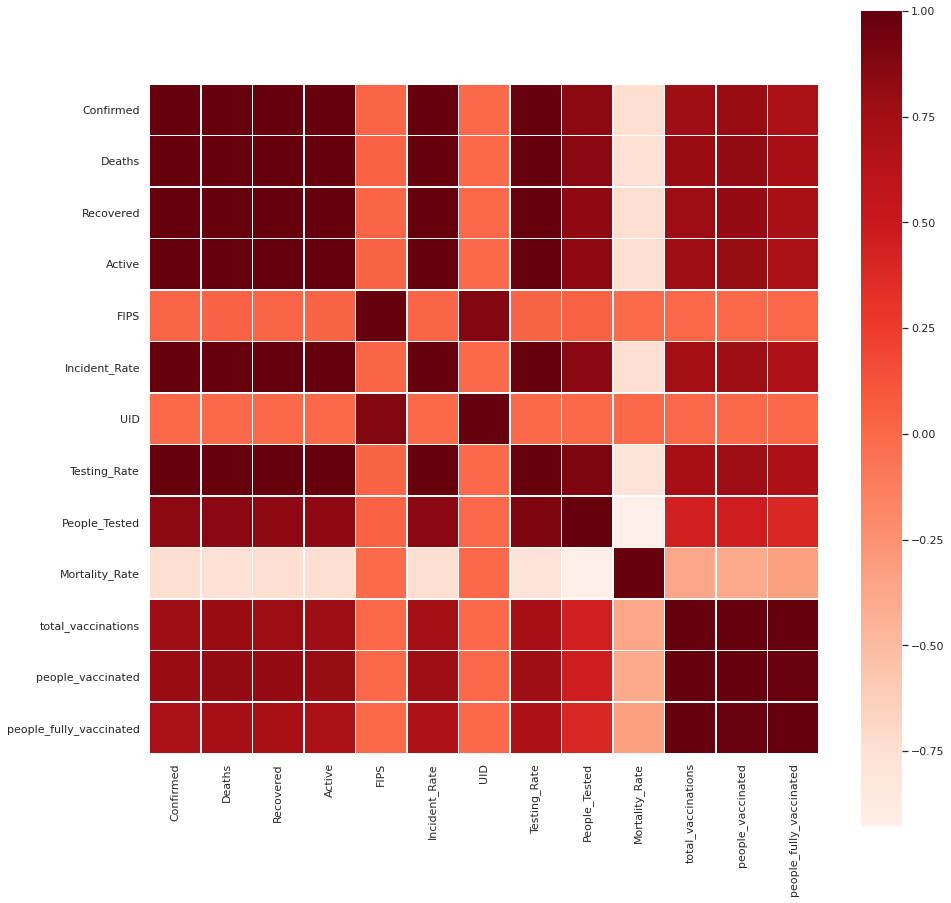

In [22]:
#Using Pearson Correlation
plt.figure(figsize=(12,12))
corr = df_bydate.corr()
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(data=corr,
            center=0,
            cmap=plt.cm.Reds, 
            square=True, linewidth=0.5)

In [24]:
#Correlation with output variable
cor_target = abs(cor['Confirmed'])
#Selecting highly correlated features
relevant_features_score = cor_target[cor_target>=0.9]
relevant_features = relevant_features_score.index.to_list()
print(relevant_features)
print(len(relevant_features))

['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'Testing_Rate']
6


In [30]:
# The first 6 columns are highly correlated, so will choose them as input for ANN model
df_bydate = df_bydate[relevant_features]
df_bydate

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Testing_Rate
0,555461,22363,1.833997e+05,533142.0,132.096557,939.956205
1,559705,23441,1.828367e+05,536688.0,139.013118,994.309773
2,628793,26725,1.876397e+05,704483.0,153.044290,1037.753196
3,636665,28718,1.898507e+05,608157.0,152.156206,1091.853820
4,667979,33279,1.940137e+05,635024.0,160.063317,1137.003935
...,...,...,...,...,...,...
345,29924740,543952,1.297356e+07,17546275.0,8379.887826,113728.130501
346,30011687,545406,1.297356e+07,17546275.0,8402.241830,114226.089775
347,30079130,546964,1.297356e+07,17546275.0,8421.184858,114603.567371
348,30156469,548085,1.297356e+07,17546275.0,8442.488181,114868.145057


#### Use MinMaxScaler to convert value beween 0 and 1


In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_labels = MinMaxScaler(feature_range=(0, 1))

# Number of predictions to the future (days)
future = 15

#How much data for training
TRAIN_SPLIT = len(df_bydate) - future - 1 
print(TRAIN_SPLIT)

#Data scaling
dataset = df_bydate.values
scaler_features.fit(dataset[:TRAIN_SPLIT])
# Get first column which is Confirmed
scaler_labels.fit(dataset[:TRAIN_SPLIT,0].reshape(-1,1))
dataset = scaler_features.transform(dataset)
print(dataset.shape)

334
(350, 6)


In [32]:
def create_timeseries(dataset, target, look_back=5):
    ''' Create time series window and return generator'''
    from keras.preprocessing.sequence import TimeseriesGenerator
    generator = TimeseriesGenerator(dataset, target, length=look_back, batch_size=1)
    return generator

In [33]:
def evaluate_model(lstm_model, dataset, TRAIN_SPLIT, generator_val, scaler_labels, title_desc="Monthly Confirmed Cases Growth in USA"):
    '''
        Evaluate and plot prediction
    '''
    from math import sqrt
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    predicted = []
    actual = []
    future_validation = 15
    future_predict = 30
    look_back = 5
    
    # Evaluate the model 
    for sample in range(future_validation - look_back):
        predict = lstm_model.predict(generator_val)
        # Inverse transofrmation
        predicted_values = scaler_labels.inverse_transform(predict[sample].reshape(1,-1))
        actual_values = scaler_labels.inverse_transform(generator_val[sample][1].reshape(1,-1))
        predicted.append(predicted_values[0][0])
        actual.append(actual_values[0][0])
    # calculate MAE
    mean_abs_error = mean_absolute_error(actual, predicted)
    print(f'MAE: {mean_abs_error:.2f}')
    # calculate RMSE
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f'RMSE: {rmse:.2f}')
    r2score = r2_score(actual,predicted)
    print(f'R2 Score: {r2score:.2f}\n')
    
    # Predict COVID confirmed cases in next 120 days
    predict_confirmed = np.copy(dataset[:TRAIN_SPLIT+1])
    for i in range(future_predict):
        # Get 5 days back from training dataset
        sample = predict_confirmed[TRAIN_SPLIT-look_back+i:TRAIN_SPLIT+i]
        # Add new dimenstion
        sample = sample.reshape((1,sample.shape[0],sample.shape[1]))
        # Predict next day
        predict = lstm_model.predict(sample)
        # Add to datatset to predict next day 
        predict_confirmed = np.vstack((predict_confirmed, predict[0]))
        
    # Inverse transofrmation
    predict_confirmed_scale = scaler_features.inverse_transform(predict_confirmed)[:,0].reshape(-1,1)
    actual_confirmed_scale = scaler_features.inverse_transform(dataset)[:,0].reshape(-1,1)
    
    # Create numpy array with start date
    date = np.array('2020-04-12', dtype=np.datetime64)
    # Generate date for each day
    date = date + np.arange(predict_confirmed.shape[0])
    # Find  total number of missing values
    missing = np.squeeze(predict_confirmed_scale).shape[0] - np.squeeze(actual_confirmed_scale).shape[0]
    # Create DateFrame date, predicted_cases, actual_cases
    df_new = pd.DataFrame({'date': date, 'predicted_cases': np.squeeze(predict_confirmed_scale), 'actual_cases': np.pad(np.squeeze(actual_confirmed_scale), (0, missing), 'constant')})
    # Replace zero with Nan
    df_new.replace(0, np.nan, inplace=True)   
    # Generate last day of each month
    month_period = df_new.groupby(pd.Grouper(key='date',freq='M'))['date'].max()
    
    month_period = df_new.groupby(pd.Grouper(key='date',freq='M'))['date'].max()
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=month_period,y=df_new.groupby(pd.Grouper(key='date',freq='M'))['actual_cases'].max(),
                             mode='lines+markers',
                             name='Actual Confirmed Cases'))
    fig.add_trace(go.Scatter(x=month_period, y=df_new.groupby(pd.Grouper(key='date',freq='M'))['predicted_cases'].max(),
                        mode='lines+markers',
                        name='Predicted Confirmed Cases'))
    fig.update_layout(title=title_desc,
                     xaxis_title="Monthly Number",yaxis_title="Number of Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
    fig.show(renderer="colab")



#### Split into train and validation dataset and convert to TimeSeries

In [34]:
# Multiple targets
generator_train = create_timeseries(dataset[:TRAIN_SPLIT],dataset[:TRAIN_SPLIT])
generator_val = create_timeseries(dataset[TRAIN_SPLIT:],dataset[TRAIN_SPLIT:])

In [35]:
x,y = generator_train[0]
print(f'Shape of x: {x.shape}')
print(f'Shape of y: {y.shape}')

Shape of x: (1, 5, 6)
Shape of y: (1, 6)


In [36]:
x,y = generator_val[0]
print(f'Shape of x: {x.shape}')
print(f'Shape of y: {y.shape}')

Shape of x: (1, 5, 6)
Shape of y: (1, 6)


### Forecast the total number of Confirmed Cased for 3 months by using Simple LSTM model

In [129]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

In [ ]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(50, input_shape=generator_train[0][0].shape[-2:], activation='relu'))
lstm_model.add(tf.keras.layers.Dense(50, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(units=generator_train[0][0].shape[-2:][1]))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
lstm_model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

history_lstm = lstm_model.fit(generator_train, batch_size =8,epochs = 100, validation_data=generator_val, verbose=2)

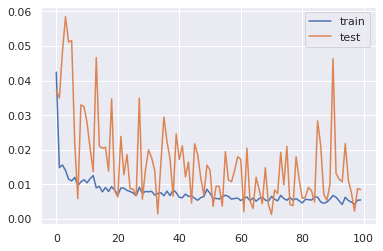

In [131]:
# plot history_lstm
from matplotlib import pyplot
pyplot.plot(history_lstm.history['loss'], label='train')
pyplot.plot(history_lstm.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [132]:
evaluate_model(lstm_model, dataset, TRAIN_SPLIT, generator_val, scaler_labels)

MAE: 220156.70
RMSE: 224469.89
R2 Score: -0.76



In [133]:
# Free up memory
del lstm_model

### Forecast the total number of Confirmed Cased for 3 months by using  Stacked LSTM model

In [ ]:
lstm_model_st = tf.keras.models.Sequential()
lstm_model_st.add(tf.keras.layers.LSTM(176, input_shape=generator_train[0][0].shape[-2:],return_sequences=True, activation='relu'))
lstm_model_st.add(tf.keras.layers.LSTM(88, activation='relu'))
lstm_model_st.add(tf.keras.layers.Dense(44, activation='relu'))
lstm_model_st.add(tf.keras.layers.Dense(22, activation='relu'))
lstm_model_st.add(tf.keras.layers.Dense(units=generator_train[0][0].shape[-2:][1]))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
lstm_model_st.compile(optimizer='adam', loss='mae')

history_st = lstm_model_st.fit(generator_train, batch_size =8,epochs = 100, validation_data=generator_val, verbose=2)

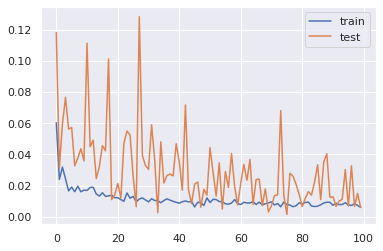

In [135]:
# plot history_lstm
pyplot.plot(history_st.history['loss'], label='train')
pyplot.plot(history_st.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [136]:
evaluate_model(lstm_model_st, dataset, TRAIN_SPLIT, generator_val, scaler_labels)

MAE: 179374.50
RMSE: 185577.70
R2 Score: -0.20



In [137]:
# Free up memory
del lstm_model_st

### Forecast the total number of Confirmed Cased for 3 months by using Bidirectional LSTM model

In [ ]:
lstm_model_bidir = tf.keras.models.Sequential()
lstm_model_bidir.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(176, input_shape=generator_train[0][0].shape[-2:],
                                                                        return_sequences=True, activation='relu')))
lstm_model_bidir.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(88, activation='relu')))
lstm_model_bidir.add(tf.keras.layers.Dense(44, activation='relu'))
lstm_model_bidir.add(tf.keras.layers.Dense(22, activation='relu'))
lstm_model_bidir.add(tf.keras.layers.Dense(units=generator_train[0][0].shape[-2:][1]))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
lstm_model_bidir.compile(optimizer='adam', loss='mae')

history_bidir= lstm_model_bidir.fit(generator_train, batch_size =8,epochs = 100, validation_data=generator_val, verbose=2)

In [ ]:
lstm_model_bidir = tf.keras.models.Sequential()
lstm_model_bidir.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, input_shape=generator_train[0][0].shape[-2:], activation='relu')))
lstm_model_bidir.add(tf.keras.layers.Dense(units=generator_train[0][0].shape[-2:][1]))
lstm_model_bidir.compile(optimizer='adam', loss='mae')

history_bidir = lstm_model_bidir.fit(generator_train, batch_size =8,epochs = 100, validation_data=generator_val, verbose=2)

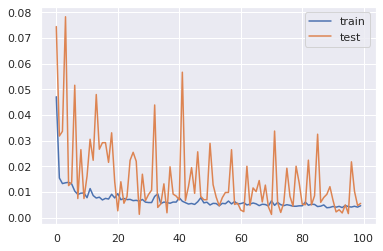

In [142]:
# plot history_bidir
from matplotlib import pyplot
pyplot.plot(history_bidir.history['loss'], label='train')
pyplot.plot(history_bidir.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [143]:
evaluate_model(lstm_model_bidir, dataset, TRAIN_SPLIT, generator_val, scaler_labels)

MAE: 80280.10
RMSE: 92028.48
R2 Score: 0.70



In [144]:
# Free up memory
del lstm_model_bidir

### Forecast the total number of Confirmed Cased for 3 months by using GRU model

In [ ]:
gru_model = tf.keras.models.Sequential()
gru_model.add(tf.keras.layers.GRU(176, input_shape=generator_train[0][0].shape[-2:], activation='relu'))
gru_model.add(tf.keras.layers.Dense(88, activation='relu'))
gru_model.add(tf.keras.layers.Dense(44, activation='relu'))
gru_model.add(tf.keras.layers.Dense(units=generator_train[0][0].shape[-2:][1]))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
gru_model.compile(optimizer='adam', loss='mae')

history_gru = gru_model.fit(generator_train, batch_size =8,epochs = 100, validation_data=generator_val, verbose=2)

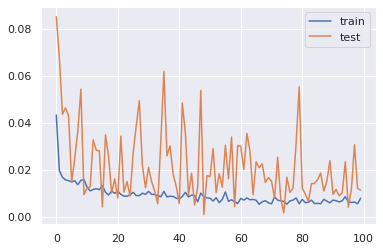

In [146]:
# plot history_gru
pyplot.plot(history_gru.history['loss'], label='train')
pyplot.plot(history_gru.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [147]:
evaluate_model(gru_model, dataset, TRAIN_SPLIT, generator_val, scaler_labels)

MAE: 170749.70
RMSE: 173651.05
R2 Score: -0.05



In [ ]:
# Free up memory
del gru_model

In [148]:
df_performance = pd.DataFrame([['Simple LSTM', 220156.70, 224469.89, -0.76],
              ['Stacked LSTM', 179374.70, 185577.70, -0.20],
              ['Bi-directional LSTM', 64951.50, 82762.03, 0.76],
              ['GRU', 170749.70, 173651.05, -0.05]], 
              columns=['Model', 'MAE', 'RMSE', 'R2_SCORE'])
df_performance

,Model,MAE,RMSE,R2_SCORE
0,Simple LSTM,220156.7,224469.89,-0.76
1,Stacked LSTM,179374.7,185577.70,-0.20
2,Bi-directional LSTM,64951.5,82762.03,0.76
3,GRU,170749.7,173651.05,-0.05


## Forecast total number of Confirmed cases for 3 months in Texas 

#### Final preprocessing

In [ ]:
# Drop columns
df_bystate.drop(columns=['Country_Region', 'date', 'Lat','Long_', 'FIPS', 'UID', 'ISO3', 'State'], inplace=True)
df_bystate

,location,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,Alabama,3667,93,102994.371019,3470.0,75.988020,0.0,437.0,0.000000,460.300152,12.264945,21583.0,2.610160,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
1,Alaska,272,8,66.000000,264.0,45.504049,0.0,31.0,0.000000,1344.711576,11.397059,8038.0,2.941176,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
2,American Samoa,0,0,0.000000,0.0,0.000000,0.0,40.0,0.000000,5.391708,14.814815,3.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
3,Arizona,3542,115,66.000000,3427.0,48.662422,0.0,31.0,0.000000,578.522286,11.397059,42109.0,3.246753,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
4,Arkansas,1280,27,367.000000,1253.0,49.439423,0.0,130.0,0.000000,761.753354,10.156250,19722.0,2.109375,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18587,Washington,346403,5077,0.000000,339491.0,4549.019927,5432587.0,6640.0,1.465634,71341.606507,9.133048,2592766.0,2.078735,2303420.0,2989200.0,1469986.0,10.76,30.25,819624.0,19.30,39.25,48238.0,59317.0,7790.0,0.771
18588,West Virginia,133856,2326,124502.000000,6465.0,7469.030163,2268494.0,100.0,1.737688,126579.683475,9.407338,849461.0,1.774398,611113.0,778825.0,370361.0,12.99,34.10,232746.0,20.67,43.46,4768.0,9951.0,5553.0,0.785
18589,Wisconsin,622444,7134,552311.000000,61861.0,10690.443206,7088211.0,5684.0,1.146127,121739.653897,7.771610,3564737.0,0.864590,1839822.0,2169885.0,1171932.0,11.21,31.60,652728.0,20.13,37.27,27366.0,40936.0,7031.0,0.848
18590,Wyoming,54972,691,53550.000000,532.0,9498.254023,652519.0,215.0,1.257004,112744.510237,5.759443,141079.0,0.658579,190180.0,259495.0,116799.0,12.25,32.86,70919.0,20.18,44.84,4367.0,3895.0,6730.0,0.733


In [ ]:
# Select data for Texas
df = df_bystate[df_bystate['location'] == 'Texas'].reset_index(drop=True).copy()
df.drop(columns=['location'], inplace=True)
df

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,13780,306,2014.0,13394.0,59.505161,0.0,1338.0,0.000000,541.811523,9.782847,124533.0,2.069167,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
1,14328,337,2269.0,13970.0,62.106907,0.0,1176.0,0.000000,579.632563,8.238179,133226.0,2.136602,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
2,15088,363,2580.0,14664.0,65.287303,0.0,1409.0,0.000000,637.240798,9.389578,146467.0,2.279088,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
3,16044,406,3150.0,15532.0,69.207326,0.0,1538.0,0.000000,660.486837,9.668699,151810.0,2.357453,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
4,16985,440,3677.0,16462.0,73.423199,0.0,1459.0,0.000000,689.797817,8.645414,158547.0,2.453188,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2688975,45047,2470308.0,173620.0,9273.644764,19820052.0,1563.0,1.675248,68354.715623,6.172742,8734857.0,1.935959,6829275.0,9250505.0,4410894.0,8.31,23.55,2409211.0,15.21,31.90,238100.0,204902.0,7067.0,0.738
328,2692691,45249,2470308.0,177134.0,9286.460377,19820052.0,1563.0,1.680438,68354.715623,6.172742,8734857.0,1.935959,6938167.0,9250505.0,4482702.0,8.44,23.93,2446292.0,15.46,31.90,108892.0,195936.0,6757.0,0.750
329,2695558,45315,2470308.0,177134.0,9296.347988,19907384.0,1563.0,1.681099,68655.903230,6.172742,8734857.0,1.935959,7071506.0,9250505.0,4406573.0,8.25,24.39,2392254.0,15.20,31.90,133339.0,214144.0,7385.0,0.764
330,2699083,45411,2470308.0,177134.0,9308.504887,19907384.0,1563.0,1.682460,68655.903230,6.172742,8734857.0,1.935959,7299866.0,9694925.0,4574899.0,8.49,25.18,2460920.0,15.78,33.44,228360.0,191891.0,6618.0,0.753


##### Use MinMaxScaler to convert value beween 0 and 1

In [81]:
from sklearn.preprocessing import MinMaxScaler
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_labels = MinMaxScaler(feature_range=(0, 1))

# Number of predictions to the future (days)
future = 20

#How much data for training
TRAIN_SPLIT = len(df) - future - 1 
print(TRAIN_SPLIT)

#Data scaling
dataset = df.values
scaler_features.fit(dataset[:TRAIN_SPLIT])
# Get first column which is Confirmed
scaler_labels.fit(dataset[:TRAIN_SPLIT,0].reshape(-1,1))
dataset = scaler_features.transform(dataset)
print(dataset.shape)

NameError: ignored

##### Split into train and validation dataset and convert to TimeSeries

In [ ]:
# Multiple targets
generator_train = create_timeseries(dataset[:TRAIN_SPLIT],dataset[:TRAIN_SPLIT])
generator_val = create_timeseries(dataset[TRAIN_SPLIT:],dataset[TRAIN_SPLIT:])

In [ ]:
x,y = generator_train[0]
print(f'Shape of x: {x.shape}')
print(f'Shape of y: {y.shape}')

Shape of x: (1, 5, 24)
Shape of y: (1, 24)


### Forecast the total number of Confirmed Cased for 3 months in Texas by using Stacked LSTM model

In [ ]:
lstm_model_st = tf.keras.models.Sequential()
lstm_model_st.add(tf.keras.layers.LSTM(176, input_shape=generator_train[0][0].shape[-2:],return_sequences=True, activation='relu'))
lstm_model_st.add(tf.keras.layers.LSTM(88, activation='relu'))
lstm_model_st.add(tf.keras.layers.Dense(44, activation='relu'))
lstm_model_st.add(tf.keras.layers.Dense(22, activation='relu'))
lstm_model_st.add(tf.keras.layers.Dense(units=generator_train[0][0].shape[-2:][1]))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
lstm_model_st.compile(optimizer='adam', loss='mae')

history_st = lstm_model_st.fit(generator_train, batch_size =8,epochs = 100, validation_data=generator_val, verbose=2)

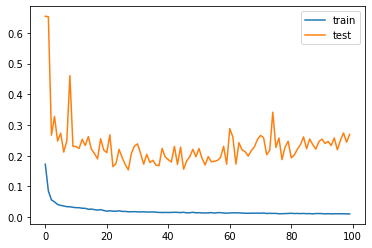

In [ ]:
# plot history_lstm
pyplot.plot(history_st.history['loss'], label='train')
pyplot.plot(history_st.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
evaluate_model(lstm_model_st, dataset, TRAIN_SPLIT, generator_val, scaler_labels, 'Monthly Confirmed Cases Growth in Texas')

RMSE: 698797.94


In [ ]:
# Free up memory
del lstm_model_st